# Partial Waves & Particle Scattering 
---
#### Author: Dylan Linthorne

This notebook considers the scattering of an electron with energy $E$ off of an unknown target. Comparing a partial wave approximation of a spherical potential to a known differential cross section, which will be a Yukawa potential as an example. The observed cross section is well described for a Yukawa potential (in length units in which k = 1) by
\begin{equation}
\frac{d\sigma}{d\Omega}= \bigg(\frac{2}{4\text{Sin}^2(\theta/2) + 1} \bigg)^2
\end{equation}

Where $\theta$ is the polar scattering angle w.r.t the incoming scattering axis. The above cross section will be compared to a partial wave expansion of a spherical shell potential centered at the scattering origin,

\begin{equation}
V(r) = 
\begin{cases}
  V_{0} & \text{if $r<a$} \\
  0 & \text{if $r\ge a$}
\end{cases}
\end{equation}

The spherical scattering bound $a$ can be choosen for the scale of the problem. The remainder of the notebook will be concerned with using the known/observed cross section (in this case, Yukawa) to constrain the partial wave parameters so to give a model that aggrees with a predefined precision.

---

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import special as sp
from scipy import integrate, optimize
import cmath

## Phase shifts $\delta_{l}$:

A necessary ingredient for modeling the partial wave expansion is the phase shift $\delta_l$ for each angular momentum quantum number $l$ (the $l^{th}$ term of the series). The generic phase shift can be found in [Sakuri],

\begin{equation}
\text{tan}(\delta_l) = \frac{aJ_{l}^{'}(a) - \beta_l J_{l}(a)}{an_{l}^{'}(a) - \beta_l n_{l}(a)}
\end{equation}

Here $(J_{l}, n_{l})$ are the spherical bessel functions of the first and second kind, and $(J_{l}^{'}, n_{l}^{'})$ are their respective derivatives. The beta function, $\beta_{l}$ is dependent on the potential used to approximate our partial wave expansion. In this case, the beta function is derived from finding the radial solution of the non-linear schrodinger equation for a given potential. The solution requires a set number of boundary conditions, for which we use the above potential $V(r)$. When calculated analytically,

\begin{equation}
\beta_{l}(a) = \frac{a k \cdot J_{l}^{'}(k a)}{J_{l}(k a)}
\end{equation}

The boundary condition on the energy giving $k = \sqrt{1 - 2 V_0}$. The user should verify the solution and change it accordingly for their assumed potential and conditions. Units are such that $\hbar/m = k = 1$.

---

In [3]:
def beta(l, a, v):
    # taking care of any singularities
    if v!= 0.5:
        # reduced k constant
        k = cmath.sqrt(1. -2.*v)
        
        num = a*k*sp.spherical_jn(l,k*a,"deritaive = True")
        dem = sp.spherical_jn(l,k*a)
        
        return num/dem
    else:
        return 1

Knowing the beta function provides the user with enough information to calculate the phase shifts.

In [4]:
def P_shift(l, a, v):
    # beta value call
    b = beta(l, a, v)
    num = a*sp.spherical_jn(l,a,"deritaive = True") - b*sp.spherical_jn(l,a);
    dem = a*sp.spherical_yn(l,a,"deritaive = True") - b*sp.spherical_yn(l,a);
    
    return num/dem

## Partial Wave Expansion:

The partial wave expansion is quantum mechanical multipole expansion in the angular momentum quantum number $l$. Similar tools will be used as would be be for electromagnetism. The full expansion is given by,

\begin{equation}
f(\text{cos}(\theta)) = \sum_{l}^{l_{max}} (2l +1)e^{i\delta_l}\text{sin}(\delta_{l}) P_{l}(\text{cos}(\theta))
\end{equation}

Where $P_{l}(\text{cos}(\theta))$ is the legendre polynomials, and $l_{max}$ is the maximum value number of terms needed to converge the series. This notebook focuses on find the appropriate maximum $l$ for a desired precision in the cross section $(\Delta \sigma)/\sigma$. The cross section is then just the probability density function squared $\sigma (\text{cos}(\theta)) = |f(\text{cos}(\theta)) |^2$

---

In [5]:
def Partial(a, v, u, lmax = 4):

    f = 0;
    for l in range(0, lmax):
        delta = np.arctan(P_shift(l, a, v));
        leg = sp.eval_legendre(l, u);
        
        f = f + (2*l + 1)*np.exp(delta*1j)*np.sin(delta)*leg
        
    return f

Define the observed/known cross section for parameter extraction (example is a Yukawa potential by default) in a form such that the independent variable is the polar parameter cos$(\theta)$. The total cross section can be calculated as well using only the phase shifts. 

In [6]:
def Yukawa(u):
    return (2./(3.-2.0*u))**2

def totalcross(a, v):
    s = 0
    for k in range(0, 1):
        
        delta = np.arctan(P_shift(k, a, v))
        s += ((2*k+1)*np.sin(delta))**2
    return s

## $\chi^2$ Minimization and Parameter Extraction:

To extract the estimated parameter to the phase shifts $(a,V_{0})$ we minimize a the (continous) $\chi^2$ with the known/observed model

\begin{equation}
\chi^2 = \int d\text{cos}(\theta) \;\bigg|\bigg(\frac{d\sigma}{d\Omega}\bigg)_{\text{observed}}- \bigg(\frac{d\sigma}{d\Omega}\bigg)_{\text{predicted}} \bigg|^2
\end{equation}

---

In [7]:
def chi2(a, v):
    result = integrate.quad(lambda x: np.abs(Yukawa(x) - np.abs(Partial(a, v, x)**2))**2, -1, 1)
    return result[0]

In [8]:
def Yukawaint(a, v):
    rest = integrate.quad(lambda x: Yukawa(x), -1, -1)
    rest[0]

### Main program: Calculations and Plots

The $\chi^2$ function will be minimized using a Nelder-Mead minimization scheme. This is due to now being able to analytically evaluating the Hessians or Jacobians. Depending on how shallow the minimums of your function are, it might be benefical to calculate these (second) derivatives.

---

In [9]:
x0 = np.array([1,1]) # starting point 
res = optimize.minimize(lambda x: chi2(x[0], x[1]) ,x0, method='nelder-mead', options={ 'disp': True})

Optimization terminated successfully.
         Current function value: 0.032990
         Iterations: 57
         Function evaluations: 112


Plotting the suface to see if the our minimum corresponds visually. A-prior information is used to restrict the bounds of the plot. 

In [10]:
xa = np.linspace(0.01,1, 40)
yv = np.linspace(0.01,5, 40)
Xgrid, Ygrid = np.meshgrid(xa, yv)

chi_map = np.zeros(Xgrid.shape)
for i,x in enumerate(xa):
    for j,y in enumerate(yv):
        chi_map[i,j] = chi2(x,y)

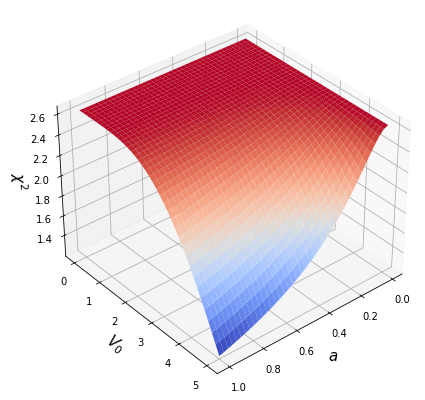

In [11]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(35, 50)
ax.plot_surface(Xgrid, Ygrid, chi_map, cmap="coolwarm")
ax.set_xlabel("$a$", fontsize = 15)
ax.set_ylabel("$V_{0}$", fontsize = 15)
ax.set_zlabel("$\chi^2$", fontsize = 15)
plt.show()

Comparing the known/observed potential with the predicted potential. Calculating the residuals and relative error between both models.

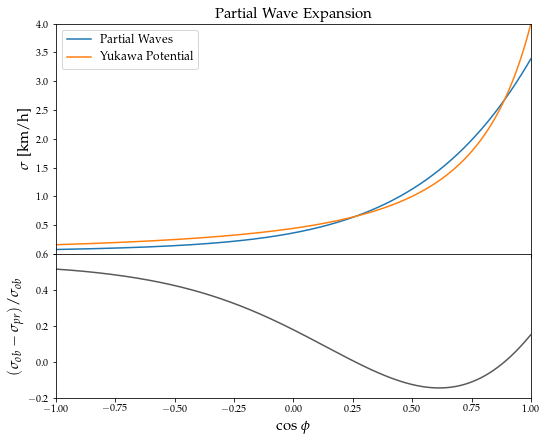

In [36]:
u = np.arange(-1,1,0.001)

partial = np.abs(Partial(res.x[0],res.x[1],u))**2;
residuals = (Yukawa(u) - partial)/Yukawa(u)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

fig2 = plt.figure()
ax1 = fig2.add_axes((0,1,1.1,.8))
ax1.plot(u,partial, label='Partial Waves');
ax1.plot(u,Yukawa(u), label='Yukawa Potential');
ax1.set_ylabel("$\sigma$ [km/h]", fontsize = 15)
ax1.set_title("Partial Wave Expansion", fontsize = 15)
plt.axis([-1,1, 0, 4])
plt.setp(ax1.get_yticklabels()[0], visible=False)    
plt.setp(ax1.get_xticklabels()[0], visible=False)    
plt.setp(ax1.get_xticklabels()[-1], visible=False)
ax1.legend( fontsize='large')
ax2 = fig2.add_axes((0,.5,1.1,.5))
ax2.plot(u, residuals, c='0.35') # this are the residuals
#plt.axhline(y=0, color='black', linestyle='--', c='0.15', linewidth = 1.3)
plt.axis([-1,1, -.2, .6])
plt.ylabel("$(\sigma_{ob} - \sigma_{pr})/\sigma_{ob} $",fontsize = 15)
plt.xlabel("cos $ \phi $",fontsize = 15)
plt.show()

In [13]:
for i in range(0,10):
    par = Partial(2.335,2,.5,i)
    print(" l = ", i -1, ":",np.abs(par))

 l =  -1 : 0
 l =  0 : 0.9711306335794682
 l =  1 : 1.7303914820745645
 l =  2 : 1.6727383876491997
 l =  3 : 1.6520098443317885
 l =  4 : 1.65100374861892
 l =  5 : 1.6510206291275085
 l =  6 : 1.6510228656778636
 l =  7 : 1.6510229068214204
 l =  8 : 1.6510229065462898
